# Assignment 2 - Leonardo Stoppani

# Image Classification with Convolutional Neural Networks on CIFAR-10

## Define and train the model 

### Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

print(X_train.shape, X_val.shape, X_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


In [3]:
# one hot encode target values
train_labels = to_categorical(y_train, num_classes=10)
val_labels = to_categorical(y_val, num_classes=10)
test_labels = to_categorical(y_test, num_classes=10)

# normalize pixel values
train_images = X_train.astype('float32') / 255
val_images = X_val.astype('float32') / 255
test_images = X_test.astype('float32') / 255

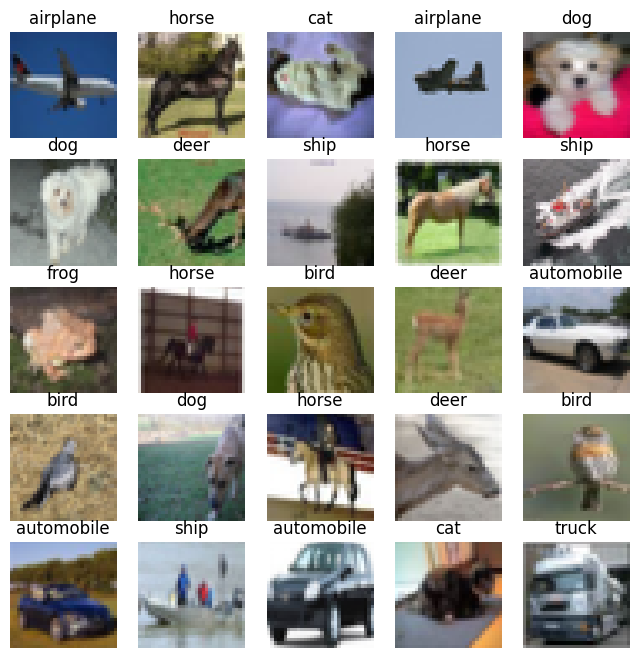

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
                'horse', 'ship', 'truck']

fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(train_images[i])
    # show labels from one hot to categorical
    ax.set_title(class_names[np.argmax(train_labels[i])])
    ax.axis('off')
plt.show()


### Data augmentation
To achieve better results, we can augment the data by applying random transformations to the images. This will allow the model to generalize better, and to be more robust to different transformations of the input images, working as regularization.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
datagen.fit(train_images)

### Define the CNN architecture
The model architecture is made of 3 convolutional layers with 32, 64 and 128 filters respectively, followed by a fully connected layer with 256 units and a softmax output layer with 10 units. The convolutional layers use a 3x3 kernel and a stride of 1, the activation function used is ReLU and the max pooling is performed with a 2x2 kernel and a stride of 2. To regularize the model, dropout is applied after each convolutional layer and after the fully connected layer. 

Different architectures have been tested, but this one had the best tradeoff between accuracy and complexity. State of the art results on CIFAR-10 are achieved with more parameters, usually 5 convolutional layers are used, with more filters and a larger fully connected layer. I try to keep the number of parameters contained to reduce the time of training, in order to perform more experiments. In this way i could also focus on the choose of hyperparameters to achieve good results.

Dropout and data augmentation were key factors to avoid overfitting and keep the training and validation accuracy close until the end of the training. Without these techniques, the model was overfitting and could not achieve more than 77% accuracy in validation.

The final model has 620.362 parameters, it takes about 20 minutes to train on a GPU and is able to reach 83% accuracy on the test set.

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 64)         

### Train the model
The model is trained for 100 epochs, with a batch size of 128, using the Adam optimizer with a learning rate of 0.001. The loss function used is categorical crossentropy, and the metric used to evaluate the model is accuracy. After training the model for 100 epochs the model was not overfitting so i decide to continue training for 50 more epochs. Early Stopping halt the training after 130 epochs, when the validation loss stopped improving.

Adam optimizer is used with default parameters. The learning rate is set to 0.001, it is a good value for Adam, and it is not too high to cause the model to diverge. The learning curve is a bit noisy, but make sense with Adam, because it is able to adapt the learning rate for each parameter, so it is normal to see some spikes in the loss curve.

The following cell are commented because the model is already trained and saved, so it is not necessary to train it again.

In [53]:
#adam = tf.keras.optimizers.legacy.Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# model.compile(optimizer=adam,
#              loss=tf.keras.losses.CategoricalCrossentropy(),
#              metrics=['accuracy'])

In [54]:
# train on gpu 
#tf.device('/device:GPU:0')

# early stopping when validation loss does not improve or overfitting occurs in 10 epochs
#early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True, mode='min')

# tensorboard callback
#! rm -rf ./logs/
#from datetime import datetime
#logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# train model with data augmentation
#history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
#                    epochs=100,
#                    validation_data=(val_images, val_labels),
#                    callbacks=[early_stopping, tensorboard_callback])

In [55]:
# continue training with early stopping for 100 more epochs
#early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True, mode='min')

# history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
#                    epochs=50,
#                    validation_data=(val_images, val_labels),
#                    callbacks=[early_stopping, tensorboard_callback])


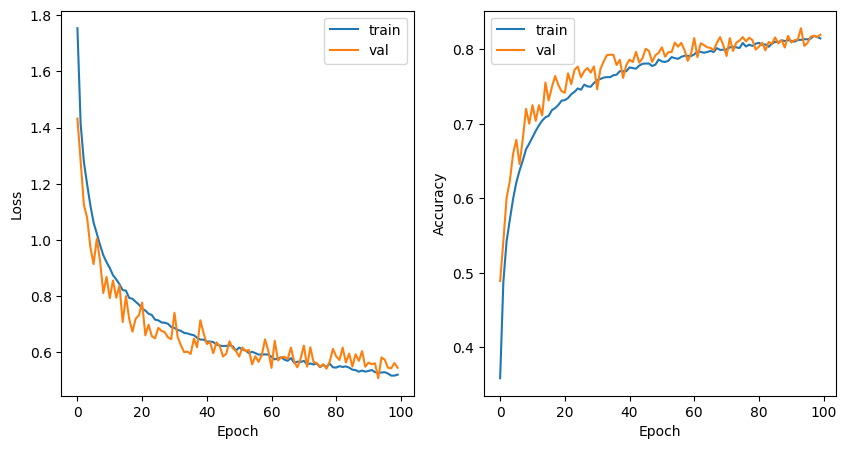

In [57]:
# plot loss and accuracy of validation and training data in subplots
#plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='val')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend()
#plt.subplot(1,2,2)
#plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='val')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

from IPython.display import Image
Image(filename='lc.png')

In [ ]:
# save the model with unique name based on number of parameters and validation accuracy
#model.save(f'cifar10_model_{model.count_params()}_{round(history.history["val_accuracy"][-1], 2)}.h5')

### Evaluate model on test set
Evaluating the model on test images shows an accuracy of 83,23%.

In [8]:
model = models.load_model('cifar10_model_620362_0.83.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc*100:.2f}%')

2023-05-09 16:22:35.328374: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 - 3s - loss: 0.5198 - accuracy: 0.8323 - 3s/epoch - 8ms/step
Test accuracy: 83.23%


Confusion matrix shows that the model is able to classify most of the images correctly. However, it makes mistake on image wich represent similar category. An obvious case is the one of `cat` and `dog`, the number of dog predicted as cat is 123. Cat and Dogs, Truck and Automobile, have similar features, a way to improve model performance could be to add the number of filter, so that the model can learn more complex features.

313/313 [==============================] - 1s 3ms/step


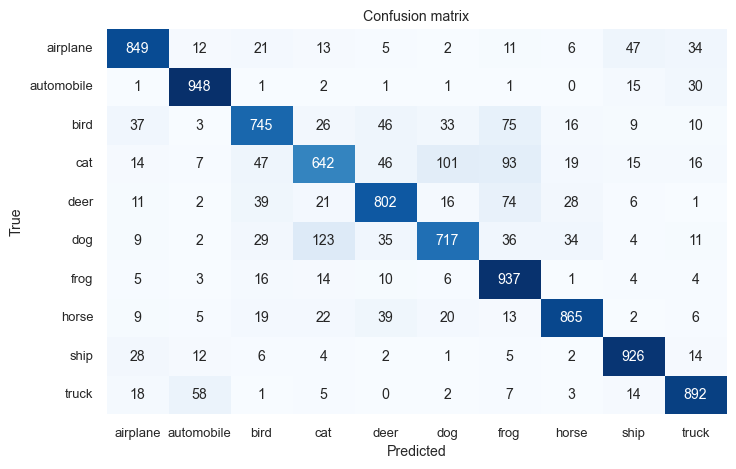

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
# label size
sns.set(font_scale=0.85)
plt.tight_layout()
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


The image above shows an example of cat misclassified.

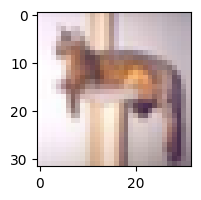

1/1 [==============================] - 0s 15ms/step
dog: 0.4774631857872009
deer: 0.3940906822681427
horse: 0.07221119105815887
cat: 0.05499938130378723
bird: 0.0011604799656197429


In [77]:
# make a prediction on a random image
random_image = np.random.randint(0, len(test_images))
plt.figure(figsize=(2, 2))
plt.imshow(test_images[random_image])
plt.show()

# predict class of random image
prediction = model.predict(test_images[random_image].reshape(1, 32, 32, 3))

# ptint the first 5 class labels with highest probability
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

## Test with occlusions

Now that we have the final model, we can test it with occluded images. First we define a function `patch_image` that take an image as input and return the same image with a gray patch of nxn size. Function allow also to specify the position of the patch. After we can start to study the behavior of the model on test images with different occlusions in size and position.

In [ ]:
def patch_image(image, x=0, y=0, n=1):
    im = image.copy()
    im[x:x+n, y:y+n] = 0.5
    return im

A patch of 10x10 size drop the probability of predicted label to be cat from 0.83 to 0.67.

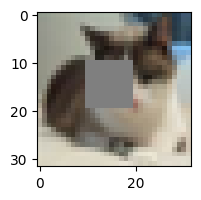

In [21]:
random_image = 3129 #gatto
patch_image1 = patch_image(test_images[random_image], 10, 10, 10)

plt.figure(figsize=(2, 2))
plt.imshow(patch_image1)
plt.show()

In [162]:
prediction = model.predict(patch_image1.reshape(1, 32, 32, 3))
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

1/1 [==============================] - 0s 14ms/step
cat: 0.669676661491394
dog: 0.29367831349372864
bird: 0.009415562264621258
truck: 0.008858528919517994
frog: 0.006101746577769518


A patch of size 15x15 in the bottom right corner of the image change the classification of the image from `truck` to `car`.

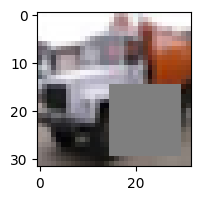

In [20]:
patch_image2 = patch_image(test_images[3409], 15, 15, 15)

plt.figure(figsize=(2, 2))
plt.imshow(patch_image2)
plt.show()

In [15]:
prediction = model.predict(patch_image2.reshape(1, 32, 32, 3))
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

1/1 [==============================] - 0s 14ms/step
automobile: 0.6405659317970276
truck: 0.3130090832710266
airplane: 0.04376723989844322
ship: 0.0021947561763226986
horse: 0.00020000821677967906


### Accuracy on occluded images

We can now check how much the accuracy on test set drops when we occlude part of the image. 

In [16]:
patched_images = []
for i in range(len(test_images)):
    patched_images.append(patch_image(test_images[i], 10, 10, 10))

patched_images = np.array(patched_images)

# compute the accuracy of the patched images
test_loss, test_acc = model.evaluate(patched_images, test_labels, verbose=2)

print(f'Test accuracy: {round(test_acc, 2)}')

313/313 - 2s - loss: 0.9288 - accuracy: 0.6988 - 2s/epoch - 8ms/step
Test accuracy: 0.7


In [ ]:
#TODO: different size of patch

### Find main pixels

By sliding a pacth of 1x1 over all the image we can also check which pixel is more important for the classification. We can see that the pixels in the center of the image are more important for the classification, while the pixels in the corners are less important.

In [17]:
def find_main_pixel(image, size):

    pix_prob = {}
    for j in range(32):
        for k in range(32):

            pp = patch_image(image, j, k, size)
            pp = pp.reshape(1, 32, 32, 3)

            prediction = model.predict(pp, verbose=0)
            prediction_prob = prediction[0][np.argsort(prediction[0])[-1]]
            prediction_name = class_names[np.argmax(prediction)]

            pix_prob[(j, k)] = (prediction_prob, prediction_name)
    
    return pix_prob

In the cat image the pixel with coordinates (14, 5) is the one that drop the most the prediction of the model. With only this pixel occluded the model turns from predict the class `cat` with 83% probability to 72%.

((14, 5), (0.72262454, 'cat'))


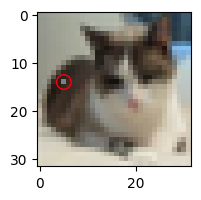

In [68]:
pix_prob = find_main_pixel(test_images[3129],1)

# pixel with lowest probability
main_pixel = min(pix_prob.items(), key=lambda x: x[1][0])

# show the image with lowest probability
x,y = main_pixel[0]
plt.figure(figsize=(2,2))

# draw a red circle around the pixel with lowest probability
circle = plt.Circle((y, x), 1.5, color='r', fill=False)
plt.gca().add_patch(circle)

plt.imshow(patch_image(test_images[3129], x, y, 1))
print(main_pixel)

In the truck image a single image cannot change the prediction, so we check with a patch of 10x10.

((16, 16), (0.86493754, 'truck'))


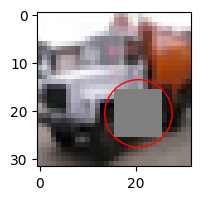

In [18]:
pix_prob_truck = find_main_pixel(test_images[3409], 10)

# pixel with lowest probability
main_pixel_truck = min(pix_prob_truck.items(), key=lambda x: x[1][0])

# show the image with lowest probability
x,y = main_pixel_truck[0]
plt.figure(figsize=(2,2))

# draw a red circle around the pixel with lowest probability
circle = plt.Circle((y+4.5, x+4.5), 7, color='r', fill=False)
plt.gca().add_patch(circle)

plt.imshow(patch_image(test_images[3409], x, y, 10))
print(main_pixel_truck)

## Final Considerations
